<a href="https://colab.research.google.com/github/YoishD/Data-Science-B7/blob/main/Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode
aa_idx = aa_encode.codes
aa_idx
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_StudentT_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 5, nu = 5)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 5,nu =10)
    μ_nu = pm.HalfStudentT('μ_nu', sigma = 5,nu =10)


    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  nu =  μ_nu,
                  dims = "aa")

    σ = pm.HalfStudentT('σ',
                       sigma = 5,
                       nu = 10,
                      dims = "aa")
    v = pm.HalfStudentT('v',
                   sigma = 5,
                   nu = 10,
                   dims = "aa")

    #likelihood; same as before
    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  nu = v[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h_StudentT = pm.sample()

Output()

Output()

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

Output()

Output()

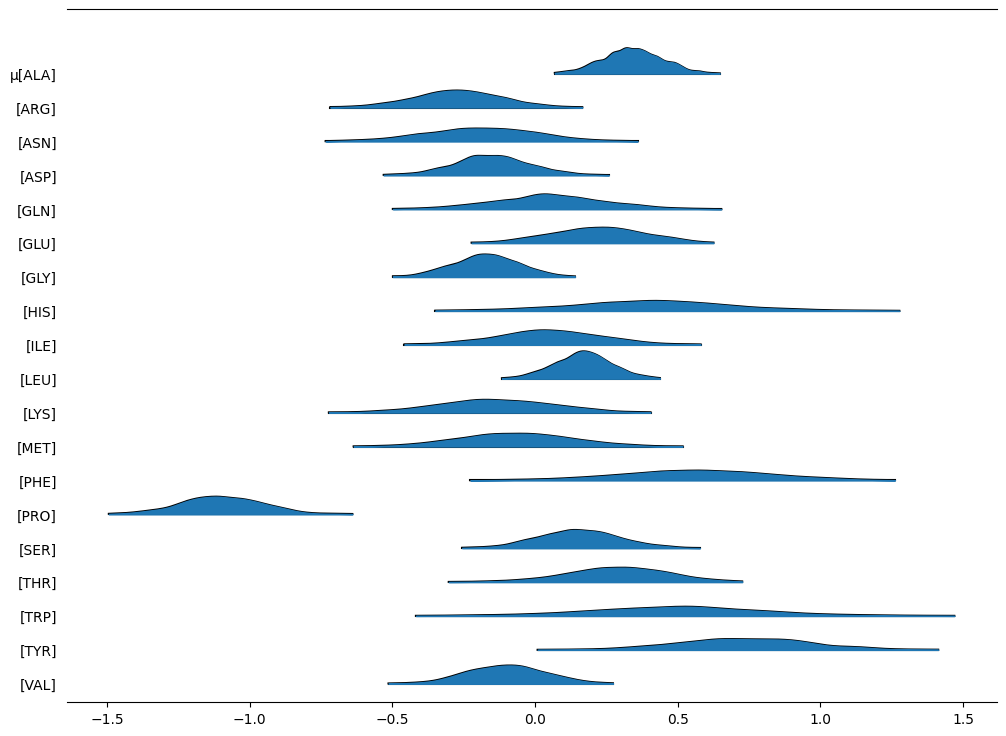

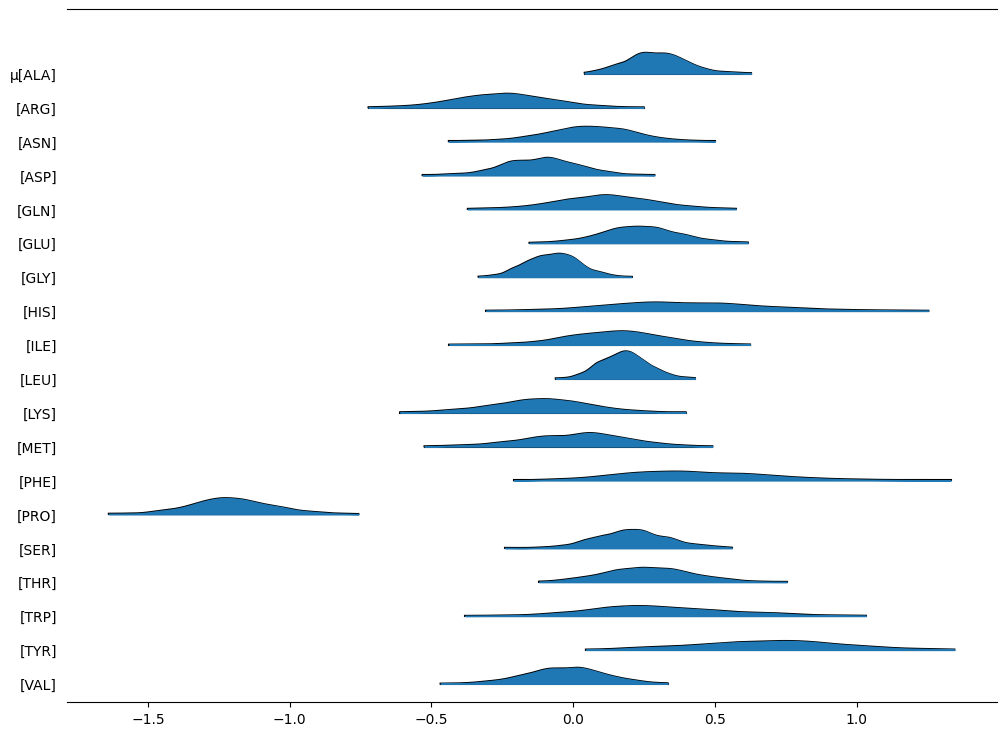

In [ ]:
axes = az.plot_forest(idata_cs_h, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)


axes = az.plot_forest(idata_cs_h_StudentT , kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

Looking at both graphs they both are pretty similar however using StudentT we are often overestimating, for example [val], and also sometimes we tend to lose some of our shape between the two likelihoods for examples their is a stark differnece between the shape of [tyr] in the normal likelihood and the shape of it in the StudentT likelihood

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

(-10.0, 10.0)

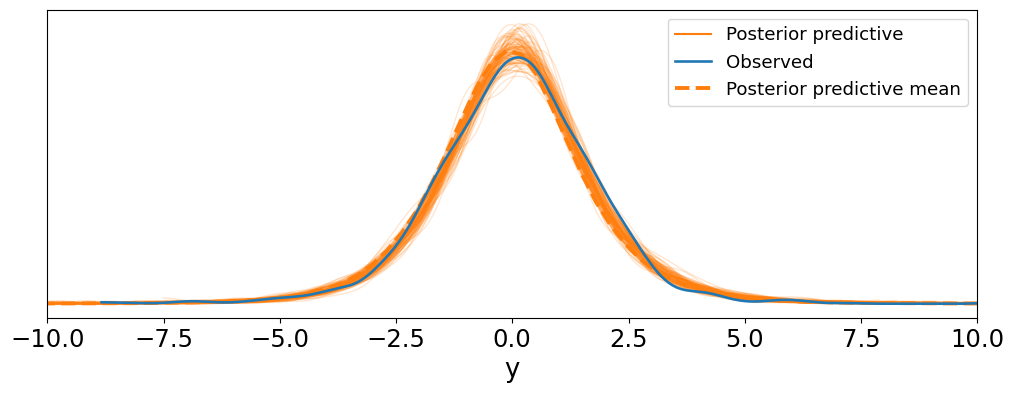

In [ ]:
pm.sample_posterior_predictive(idata_cs_h_StudentT, model=cs_h_StudentT_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_cs_h_StudentT, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
#need to limit the x axis, so its more readable
ax.set_xlim(-10,10)

Output()

<bound method _AxesBase.set_xlim of <Axes: xlabel='y'>>

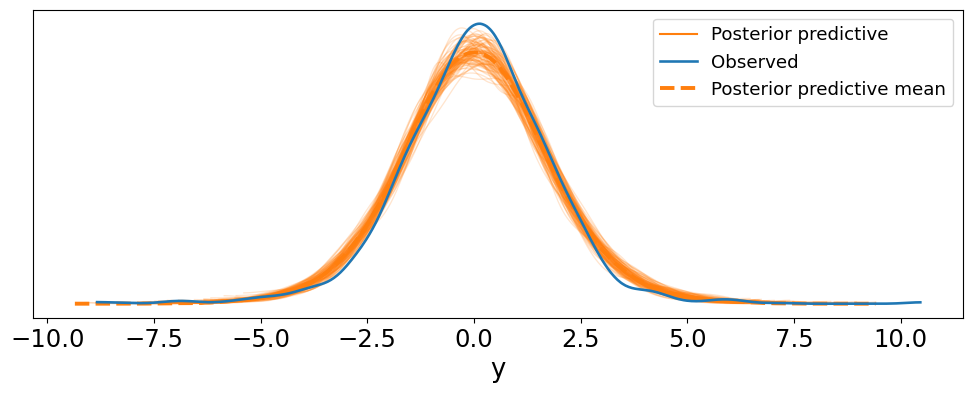

In [ ]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
#need to limit the x axis, so its more readable
ax.set_xlim

Both PPC are pretty similar, our Normal underassumes areas we are low on and over estimates our peaks, our StudentT however is just underestimating on our negative y and is overestimatng at when y is positive. overall I think that StudentT tends to fit the data better.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
pos_idx = sccr_data.position.cat.codes.values
pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

In [ ]:

with pm.Model(coords = sccr_coords) as sccr_model:
    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = 0.1, nu = 45, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player


    idata_sccr = pm.sample(target_accept=0.95)


Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

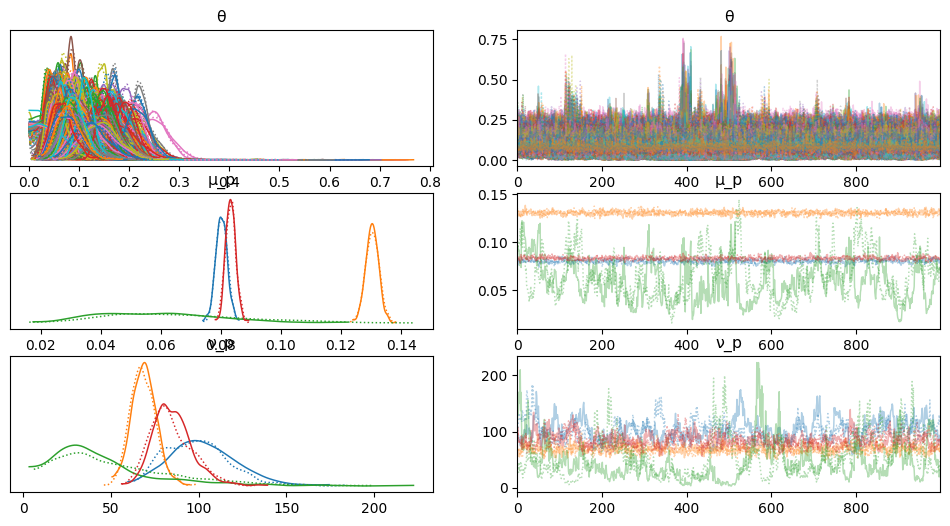

In [ ]:
az.plot_trace(idata_sccr)


In [ ]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 0.9998 1.002 1.005 0.9998 ... 1.0 1.004 1.0
    μ_p      (pos) float64 32B 1.004 1.003 1.019 1.002
    ν_p      (pos) float64 32B 1.035 1.001 1.043 1.014

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:03:24

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


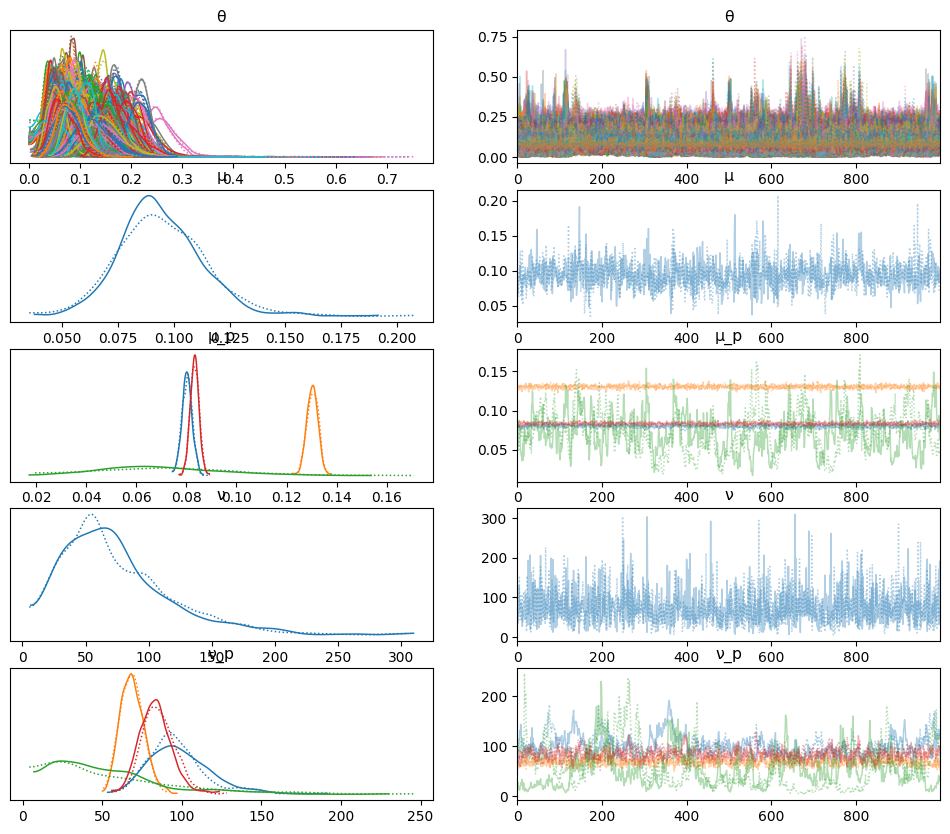

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_h_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_h = pm.sample(target_accept = 0.95)

    az.plot_trace(idata_sccr_h)
    az.rhat(idata_sccr_h)

Main differnences is that their are more graphs present on the heirarchical one (because the two extra graphs are for the priors) and that also the shapes of the graphs are also different. For example if you look at the peak of the red graph of the last graph, their are two peaks however in the heirarchical graph, their is only one.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

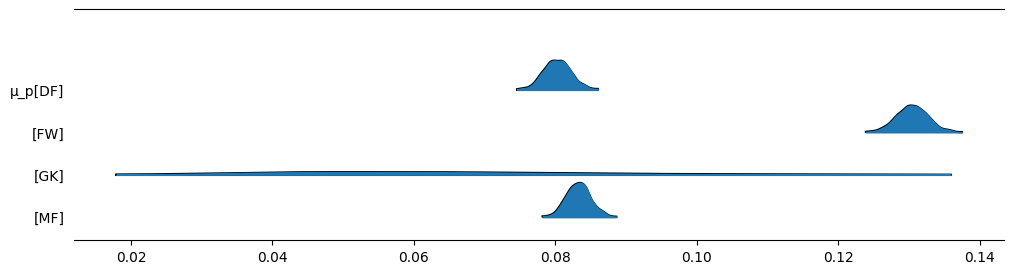

In [ ]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

array([<Axes: >], dtype=object)

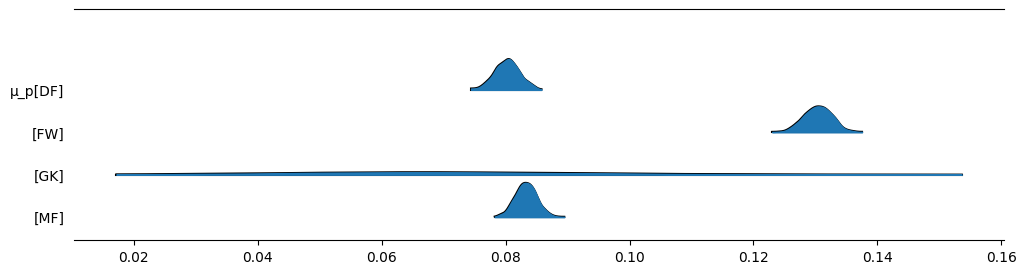

In [ ]:
az.plot_forest(idata_sccr_h, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)


We can see how the means are higher under non hierarchical liklihood compared to the one we have in our notes

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [ ]:
sccr_data
no_gk_data = sccr_data.loc[sccr_data["position"] != "GK"]
no_gk_data
pos_idx = no_gk_data.position.cat.codes.values
pos_codes = no_gk_data.position.cat.categories
sccr_coords_no_gk = {"pos": pos_codes}

In [ ]:
with pm.Model(coords = sccr_coords_no_gk) as sccr_h_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = no_gk_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = no_gk_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_no_gk = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 0.9996 1.003 1.001 1.001 ... 1.0 1.003 1.001
    μ        float64 8B 1.0
    μ_p      (pos) float64 32B 1.002 1.0 1.0 1.001
    ν        float64 8B 1.0
    ν_p      (pos) float64 32B 1.018 1.003 0.9998 1.003

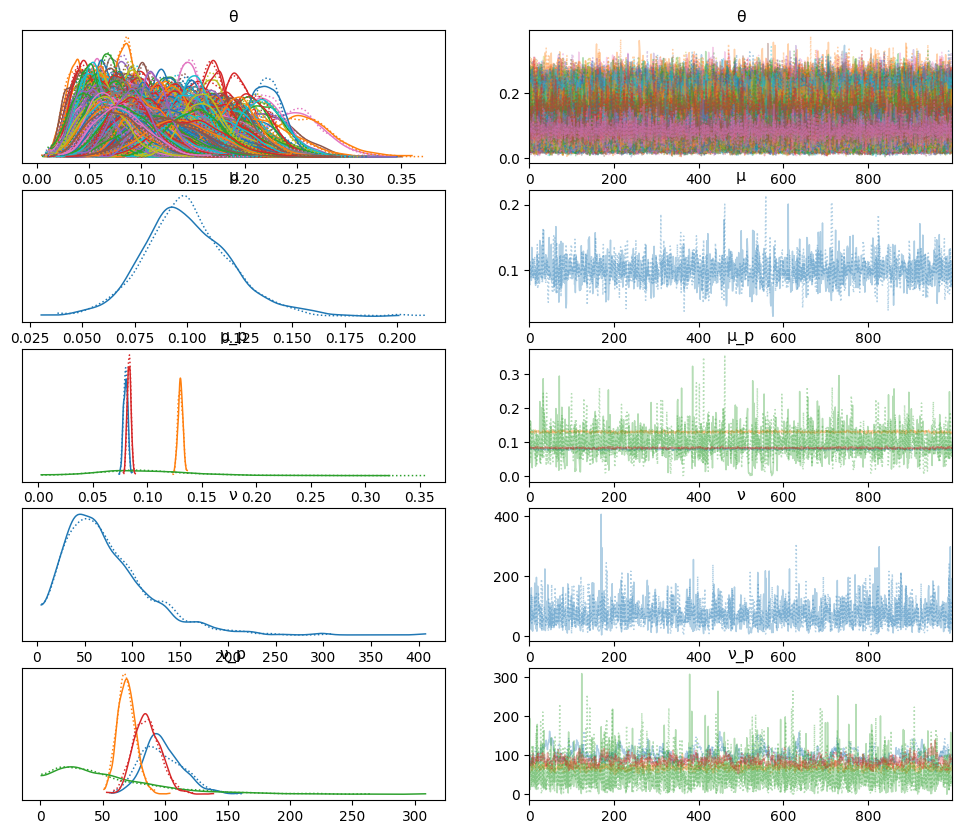

In [ ]:
 az.plot_trace(idata_sccr_no_gk)
az.rhat(idata_sccr_no_gk)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.002 1.0 1.002 ... 1.001 1.001 1.001
    μ        float64 8B 1.003
    μ_p      (pos) float64 32B 1.003 1.001 1.015 0.9999
    ν        float64 8B 1.002
    ν_p      (pos) float64 32B 1.032 1.012 1.07 1.007

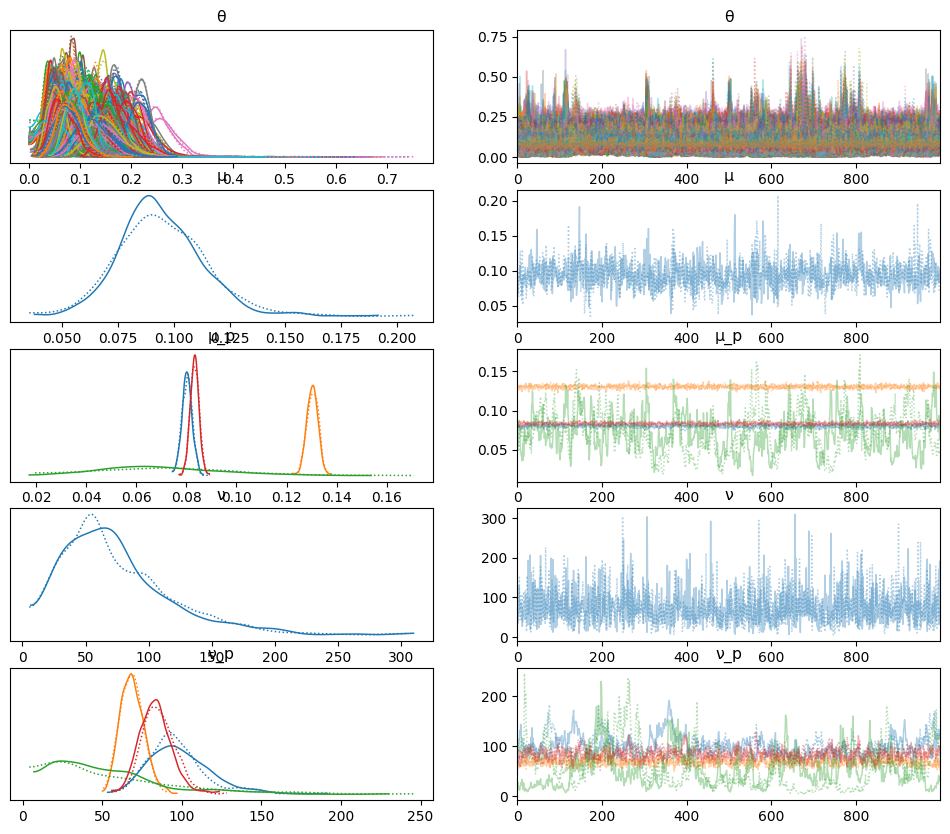

In [ ]:
az.plot_trace(idata_sccr_h)
az.rhat(idata_sccr_h)

  I think that the noGK model was easier to process because of how we are simply dealing with less data. We do los
  Our data becomes actually more inline with our predicted (the dotted lines) without gks but we are tending to actually understimated at time which is a depature from our overestimated with GK.